## Problem Set 3 - First Model Run
Mingtao Gao

In last week, we processed financial data and email metadata and visualized possible features for analysis. We identified the following features to be salient for our Machine Learning models: 1) salary, 2) bonus, 3) bonus-to-salary ratios, 4) # of emails from POIs, 5) # of emails to POI, 6) from_poi_ratio, 7) to_poi_ratio.

For our final project, Ishan and I plan to run six different machine learning models and compare the results. In this assignment, I will construct logistic regression model with data we processed last week. I will first analyze feature importances and select the best features for prediction. Next, I will build logistic regression models in three different ways: 
1) use cross validation and parameter tuning to run the model with sklearn.  
2) use Tensorflow to construct logistic regression model.  
3) use PCA to reduce the variables and construct logisitc regression model with sklearn.  

Logistic Regression is a machine learning classification algorithm that can used to predict the probability of a categorical dependent variable. The dependent variable is a binary variable, in this case, whether the insider is POI or non-POI. I will evaluate each model's performance based on accuracy, precision, and recall to decide which logistic model outperform the other two and will be used for final project.

In [1]:
import re
import os
import pprint
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
df = pd.read_csv('enron.csv', index_col = 0)
df.head()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,...,from_all,to_all,from_insider,to_insider,from_poi,to_poi,from_poi_ratio,to_poi_ratio,from_poi_ratio_2,to_poi_ratio_2
insider,,,,,,,,,,,,,,,,,,,,,
"ALLEN, PHILLIP K",201955.0,4175000.0,304805.0,-3081055.0,2869717.0,0.0,152.0,13868.0,0.0,4484442.0,...,76,2099,13,83,0,24,0.000000,0.011434,0.000000,0.289157
"BADUM, JAMES P",0.0,0.0,0.0,0.0,178980.0,0.0,0.0,3486.0,0.0,182466.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
"BANNANTINE, JAMES M",477.0,0.0,0.0,-5104.0,0.0,0.0,864523.0,56301.0,0.0,916197.0,...,9,15,9,2,3,0,0.333333,0.000000,0.333333,0.000000
"BAXTER, JOHN C",267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,0.0,2660303.0,11200.0,0.0,5634343.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
"BAY, FRANKLIN R",239671.0,400000.0,0.0,-201641.0,260455.0,0.0,69.0,129142.0,0.0,827696.0,...,4,1,0,1,0,0,0.000000,0.000000,NaN,0.000000


### Pre-Processing

From the dataframe, we found some values in from_poi_ratio, to_poi_ratio, from_poi_ratio_2, to_poi_ratio_2 are NaN becaue those denominators are 0. Therefore, I will replace those NaNs with the mean value of columns grouped by POI/non-POI. Because this dataset is already relatively small, dropping all NaNs will reduce its size further. So, I choose to replace with the mean.

In [3]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
email_ratios = ['from_poi_ratio', 'to_poi_ratio', 
                'from_poi_ratio_2', 'to_poi_ratio_2']

# Group by POI or non-POI
df_poi = df[df['POI'] == 'Yes']
df_nonpoi = df[df['POI'] == 'No']

# Replace NaN email data with the mean
df_poi.loc[:, email_ratios] = imputer.fit_transform(df_poi.loc[:, email_ratios])
df_nonpoi.loc[:, email_ratios] = imputer.fit_transform(df_nonpoi.loc[:, email_ratios])
df = df_poi.append(df_nonpoi)
df.head()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,...,from_all,to_all,from_insider,to_insider,from_poi,to_poi,from_poi_ratio,to_poi_ratio,from_poi_ratio_2,to_poi_ratio_2
insider,,,,,,,,,,,,,,,,,,,,,
"BELDEN, TIMOTHY N",213999.0,5249999.0,0.0,-2334434.0,2144013.0,0.0,210698.0,17355.0,0.0,5501630.0,...,226,382,105,14,3,0,0.013274,0.000000,0.028571,0.000000
"BOWEN JR, RAYMOND M",278601.0,1350000.0,974293.0,-833.0,0.0,0.0,1621.0,65907.0,0.0,2669589.0,...,25,17,17,0,6,0,0.240000,0.000000,0.352941,0.438452
"CALGER, CHRISTOPHER F",240189.0,1250000.0,375304.0,-262500.0,0.0,0.0,486.0,35818.0,0.0,1639297.0,...,110,102,39,24,20,2,0.181818,0.019608,0.512821,0.083333
"CAUSEY, RICHARD A",415189.0,1000000.0,350000.0,-235000.0,0.0,0.0,307895.0,30674.0,0.0,1868758.0,...,70,37,49,0,3,0,0.042857,0.000000,0.061224,0.438452
"COLWELL, WESLEY",288542.0,1200000.0,0.0,-144062.0,27610.0,0.0,101740.0,16514.0,0.0,1490344.0,...,64,18,42,2,20,0,0.312500,0.000000,0.476190,0.000000


In [4]:
# Map POI to True/False
df['poi'] = df['POI'].map({'Yes':True ,'No':False})

# Drop irrelevent columns
df.drop(['position', 'email_address', 'POI'], axis=1, inplace=True)

# Reorder the columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,...,from_all,to_all,from_insider,to_insider,from_poi,to_poi,from_poi_ratio,to_poi_ratio,from_poi_ratio_2,to_poi_ratio_2
insider,,,,,,,,,,,,,,,,,,,,,
"BELDEN, TIMOTHY N",True,213999.0,5249999.0,0.0,-2334434.0,2144013.0,0.0,210698.0,17355.0,0.0,...,226,382,105,14,3,0,0.013274,0.000000,0.028571,0.000000
"BOWEN JR, RAYMOND M",True,278601.0,1350000.0,974293.0,-833.0,0.0,0.0,1621.0,65907.0,0.0,...,25,17,17,0,6,0,0.240000,0.000000,0.352941,0.438452
"CALGER, CHRISTOPHER F",True,240189.0,1250000.0,375304.0,-262500.0,0.0,0.0,486.0,35818.0,0.0,...,110,102,39,24,20,2,0.181818,0.019608,0.512821,0.083333
"CAUSEY, RICHARD A",True,415189.0,1000000.0,350000.0,-235000.0,0.0,0.0,307895.0,30674.0,0.0,...,70,37,49,0,3,0,0.042857,0.000000,0.061224,0.438452
"COLWELL, WESLEY",True,288542.0,1200000.0,0.0,-144062.0,27610.0,0.0,101740.0,16514.0,0.0,...,64,18,42,2,20,0,0.312500,0.000000,0.476190,0.000000


### Scaling  

This step aims to normalize the dataset so that each column has a zero mean and a unit variance. Because each column has different units in this case, scaling is necessary for contructing machine learning models in the next step. Scaling allows me to compare different variables on equal footing. I used the scale function provided by the sklearn preprocessing module. 

In [5]:
scaled_df = df.copy()
scaled_df.iloc[:, 1:] = scale(scaled_df.iloc[:, 1:])

### Feature Selection  
To select specific features to build machine learning models, I used the automated feature selection function provided by the sklearn library, SelectKBest. 

In [6]:
my_dataset = scaled_df.to_dict(orient='index')

# Seperate target feature and other features as two lists
labels = []
features = []    
for key in my_dataset.keys():
    lst = [my_dataset[key][col] for col in cols]
    labels.append(lst[0])
    features.append(np.array(lst[1:]))

We will tune the parameter K (number of features) at the same time we tune the parameters of the machine learning algorithm during the implementation of cross-validation. If we select the number of features on the entire data set and then we tune the parameters of the machine learning algorithm there is a risk of overfitting.

In [7]:
# Find Top 10 most important features
selector = SelectKBest(f_classif, k=10)
selector.fit(features, labels)
scores = zip(cols[1:], selector.scores_)

print('SelectKBest scores: ')
sorted_scores = sorted(scores, key=lambda x: x[1], reverse = True)
pprint.pprint(sorted_scores)

print ('\n Features selected:')
features_selected=[cols[i+1] for i in selector.get_support(indices=True)]
pprint.pprint(features_selected)

SelectKBest scores: 
[('total_stock_value', 24.30791375858266),
 ('salary', 24.049488518125855),
 ('stock_op_exercised', 22.61053070687378),
 ('bonus', 21.793282673182844),
 ('deferred_income', 16.386700145802614),
 ('from_poi', 16.056981299907683),
 ('to_poi_ratio_2', 14.964580117045703),
 ('from_poi_ratio_2', 13.649407553300755),
 ('bonus_salary_ratio', 11.04644979417711),
 ('long_term_incentive', 10.8669574026598),
 ('total_payments', 10.028615421567002),
 ('restrict_stock', 9.575866371215845),
 ('other', 7.324079172210604),
 ('loan_advances', 7.298396699220318),
 ('expenses', 5.8942515242618665),
 ('from_insider', 5.375155572084904),
 ('from_poi_ratio', 5.27166068871788),
 ('to_poi_ratio', 3.51027321689051),
 ('director_fees', 2.1127619890604548),
 ('from_all', 1.041418451130992),
 ('restrict_stock_deferred', 0.7618633145602356),
 ('to_poi', 0.1574339256553093),
 ('to_all', 0.11518993778966989),
 ('to_insider', 0.08060402036528425),
 ('deferral_payments', 0.07829135735852705)]

 Fe

In [8]:
final_features = ['poi'] + features_selected
features_list = df[final_features].reset_index().drop('insider', axis=1)
features_list.head()

,poi,salary,bonus,long_term_incentive,deferred_income,stock_op_exercised,total_stock_value,bonus_salary_ratio,from_poi,from_poi_ratio_2,to_poi_ratio_2
0,True,213999.0,5249999.0,0.0,-2334434.0,953136.0,1110705.0,24.532820,3,0.028571,0.000000
1,True,278601.0,1350000.0,974293.0,-833.0,0.0,252055.0,4.845639,6,0.352941,0.438452
2,True,240189.0,1250000.0,375304.0,-262500.0,0.0,126027.0,5.204235,20,0.512821,0.083333
3,True,415189.0,1000000.0,350000.0,-235000.0,0.0,2502063.0,2.408542,3,0.061224,0.438452
4,True,288542.0,1200000.0,0.0,-144062.0,0.0,698242.0,4.158840,20,0.476190,0.000000


Because if we select all features to run the model, there is a risk of overfitting, I selected the top 10 features, including salary, bonus, long_term_incentive, deferred_income, stock_op_exercised, total_stock_value, bonus_salary_ratio, from_poi, from_poi_ratio_2, to_poi_ratio_2. 

### Logistic Regression

#### 1. Cross-validation & Hyperparameter tunning 

In [9]:
# Simple logisitic regression model with cross-validation
lr_clf = LogisticRegression()
scores = sklearn.model_selection.cross_val_score(lr_clf, features, labels, cv=5)
np.mean(scores)

0.8748768472906404

The score indicates the accuracy of the model against training data at each cross validation round. The results above show that this basic model performed not bad in predicting POI, with a mean accuracy score at 87.49%.

Next, I will use GridSearchCV to determine optimum classifer parameters for logisitc regression.

In [10]:
# Function used to tune the algorithm using grid search 
# and prints out the average evaluation metrics results (accuracy, percision, recall)
def tuning_params(grid_search, features, labels, params, iters=50):
    acc = []
    pre = []
    recall = []
    
    for i in range(iters):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.20, random_state = i)
        grid_search.fit(features_train, labels_train)
        predicts = grid_search.predict(features_test)
        
        acc = acc + [accuracy_score(labels_test, predicts)] 
        pre = pre + [precision_score(labels_test, predicts)]
        recall = recall + [recall_score(labels_test, predicts)]
    
    print ("accuracy: {}".format(np.mean(acc)))
    print ("precision: {}".format(np.mean(pre)))
    print ("recall: {}".format(np.mean(recall)))

    best_params = grid_search.best_estimator_.get_params()
    for param_name in params.keys():
        print("%s = %r, " % (param_name, best_params[param_name]))

In [11]:
# Logistic regression model with paremeter tuning ('C' and 'tol')
lr_clf = LogisticRegression()
lr_param = {'tol': [1, 0.1, 0.01, 0.001, 0.0001],
            'C': [0.1, 0.01, 0.001, 0.0001]}
lr_grid_search = GridSearchCV(estimator = lr_clf, param_grid = lr_param)

print("Logistic Regression model evaluation")
tuning_params(lr_grid_search, features, labels, lr_param)

Logistic Regression model evaluation
accuracy: 0.8689655172413793
precision: 0.34333333333333327
recall: 0.17004761904761906
tol = 0.01, 
C = 0.1, 


After evaluating logistic regression model using GridSearchCV and finding the optimum parameters for the dataset, the accuracy of prediction did not improve from simple logistic regression model we constructed in the previous step. Especially, if we take a look at precision and recall, we found this model generates high accuracy but low precision and recall. Because our data is relatively small and the number of POIs is low, low precision and recall indicate this model might be good at predicting true negatives (non-POIs) but not good at predicting true positives (POIs).

#### 2. Tensorflow
Because traditional machine learning model with sklearn did not perform well in predicting POIs, I will build regression model using TensorFlow, an open-source library developed by Google primarily for deep learning applications.

In [12]:
# Split testing and training 
y = features_list['poi']
X = features_list.drop('poi', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [13]:
# One-hot encoding
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=10))
model.add(Dense(units=2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

The loss function I choose is sparse_categorical_crossentropy. It computes the crossentropy loss between the labels and predictions. This crossentropy loss function can be used when there are two or more label classes, in this case, POI and non-POIs. 

In [17]:
# Fit the model
history = model.fit(X_train, y_train, epochs=100, shuffle=True, verbose=0);

In [18]:
# Visualize the model's training progress
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,epoch
95,0.323293,0.87963,95
96,0.322969,0.87963,96
97,0.323775,0.87963,97
98,0.322914,0.87963,98
99,0.324722,0.87963,99


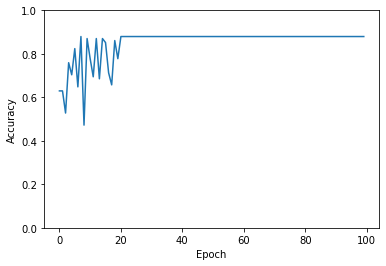

In [19]:
# Plot accuracy
plt.plot(hist['epoch'], hist['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.show()

The results show after 100 epochs, the regression model performed well on predicting training dataset, with accuracy 87.96%. It has a slightly higher accuracy than previous logistic regression model built with sklearn.

In [20]:
print("Test Accuracy: %f" % model.evaluate(X_test, y_test, verbose=0)[1])

Test Accuracy: 0.861111


It perfomed well on testing dataset too, with an accuracy of 86.11%

#### 3. Logistic Regression with PCA

Instead of using SelectKBest to find the best features and build logistic model, we can also use PCA to reduce dimensionality, and fit logistic regression model to PCA components. 

In [9]:
# Implement PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(features)
scaled_df['pca'] = [r for r in reduced_data]

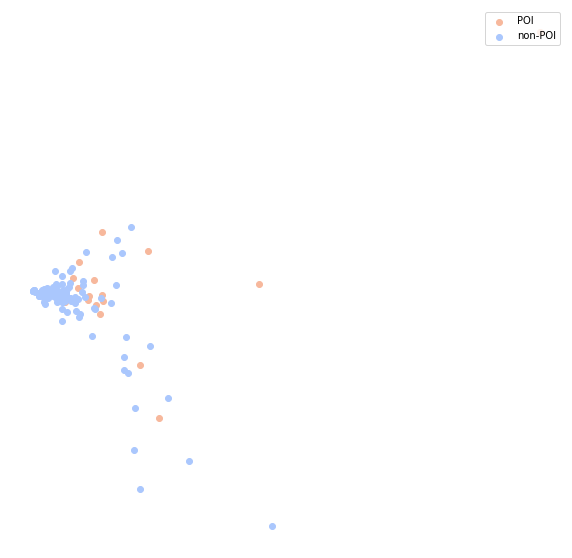

In [10]:
# Visualize in 2-D
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = sns.color_palette(palette='coolwarm', n_colors = 2)

#Plot POI
a = np.stack(scaled_df[scaled_df['poi']]['pca'])
ax.scatter(a[:,0], a[:, 1], c=pallet[1], label = "POI")

#Plot non-POI
a = np.stack(scaled_df[scaled_df['poi'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c=pallet[0], label = "non-POI")
    
ax.legend(loc = 'upper right')
plt.show()

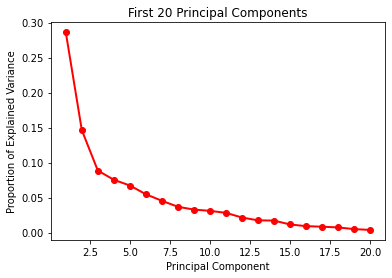

In [11]:
# Choose the optimal number of principle components
n = len(df)
eigen_vals = np.arange(20) + 1
plt.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
plt.title('First 20 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')
plt.show()

The above plot shows the fraction of total variance retained vs. the number of principal components taken. Becuase we do not want to overfit the dataset, I'll choose the first 10 principal components as my covariates.

In [12]:
scaled_df['pca_reduced_10'] = scaled_df['pca'].apply(lambda x: x[:10])

In [13]:
def trainTestSplit(df, holdBackFraction = .2):
    df = df.reindex(np.random.permutation(df.index))
    holdBackIndex = int(holdBackFraction * len(df))
    train_data = df[holdBackIndex:].copy()
    test_data = df[:holdBackIndex].copy()
    return train_data, test_data

# Split the dataset into training data and testing data
train_df, test_df = trainTestSplit(scaled_df)

In [14]:
# Fit a logistic regression
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_df['pca_reduced_10'], axis=0), train_df['poi'])

print("Training: ")
print(logistic.score(np.stack(train_df['pca_reduced_10'], axis=0), train_df['poi']))
print("Testing: ")
print(logistic.score(np.stack(test_df['pca_reduced_10'], axis=0), test_df['poi']))

Training: 
0.9224137931034483
Testing: 
0.8928571428571429


The logistic regression model constructed with PCA outperformed the other two, resulting in highest accuracy for both training and testing datasets.

In [15]:
# More evaluations on predictions
test_df['logistic_predict'] = logistic.predict(np.stack(test_df['pca_reduced_10'], axis=0))

print('Accuracy:')
print(sklearn.metrics.accuracy_score(test_df['poi'], test_df['logistic_predict']))
print('Precision:')
print(sklearn.metrics.precision_score(test_df['poi'], test_df['logistic_predict']))
print('Recall:')
print(sklearn.metrics.recall_score(test_df['poi'], test_df['logistic_predict']))
print('F-measures:')
print(sklearn.metrics.f1_score(test_df['poi'], test_df['logistic_predict']))

Accuracy:
0.8928571428571429
Precision:
1.0
Recall:
0.4
F-measures:
0.5714285714285715


Unlike previous logistic model, this model received high precision and high recall values, indicating it successfully predicted the test dataset. 

In [16]:
# Plot confusion matrix
def plotConfusionMatrix(clf, testDF, feature, target):
    predictions = clf.predict(np.stack(testDF[feature], axis=0))
    mat = sklearn.metrics.confusion_matrix(testDF[target], predictions)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=testDF[target].unique(), yticklabels=testDF[target].unique())
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title("Confusion Matrix")
    plt.show()
    plt.close()

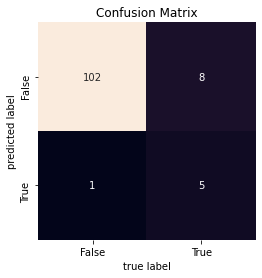

In [17]:
plotConfusionMatrix(logistic, train_df, 'pca_reduced_10', 'poi')

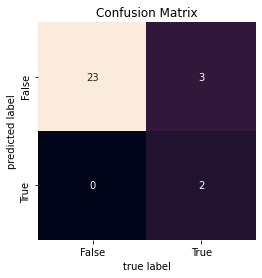

In [18]:
plotConfusionMatrix(logistic, test_df, 'pca_reduced_10', 'poi')

The confusion matrix for both training and testing datasets predictions show the model perfomed well in predictions, resulting in low number of false positive and false negative errors. 

In [31]:
# Plot ROC
# Method from https://github.com/Computational-Content-Analysis-2020/lucem_illud_2020/blob/master/lucem_illud_2020/metrics.py
def plotMultiROC(clf, testDF, feature, target):
    classes = clf.classes_
    probs = clf.predict_proba(np.stack(testDF[feature], axis=0))
    predictions = clf.predict(np.stack(testDF[feature], axis=0))

    fig, ax = plt.subplots(figsize = (10,10))

    aucVals = []
    for classIndex, className in enumerate(classes): 
        truths = [1 if c == className else 0 for c in testDF[target]]
        predict = [1 if c == className else 0 for c in predictions]
        scores = probs[:, classIndex]

        #Get the ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(truths, scores)
        auc = sklearn.metrics.auc(fpr, tpr)
        aucVals.append(auc)

        #Plot the class's line
        ax.plot(fpr, tpr, label = "{} (AUC ${:.3f}$)".format(str(className).split(':')[0], auc))

    #Make the plot nice, then display it
    ax.set_title('Receiver Operating Characteristics')
    plt.plot([0,1], [0,1], color = 'k', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right')
    plt.show()
    plt.close()

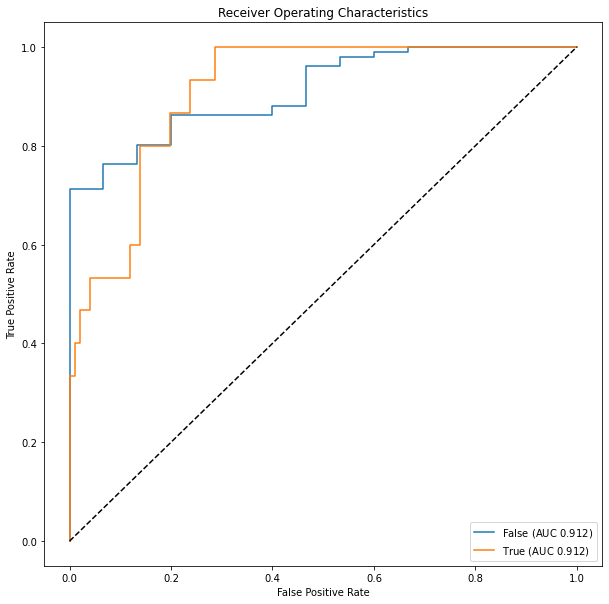

In [32]:
plotMultiROC(logistic, train_df, 'pca_reduced_10', 'poi')

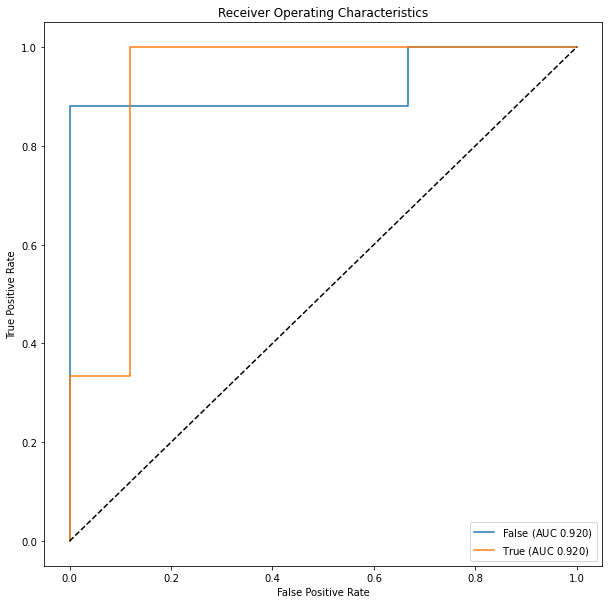

In [33]:
plotMultiROC(logistic, test_df, 'pca_reduced_10', 'poi')

Plots above present the ROC curves and AUC values for both training and testing dataset. This logistic regression classifier shows excellent performance.

### Next Step

In this section, I deployed three different ways to contruct logistic regression model to fit the Enron finantial + email dataset. As a result, the sklearn logistic regression model constructed with PCA components outperformed the other two and it will be used for our final project, in comparison with other five classification models (Naive Bayes, Decision Tree, K-Nearest Neighbors, AdaBoost, and SVM). 

For this week's assignment, Ishan will run and evaluate Decision Tree model with our dataset. In the next following weeks, we will each build, run, and evaluate another two machine learning models and compare the results for our final project. 